In [35]:
!pip install d2l==1.0.0b0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 3.1 Linear Regression

코드적으로는 그냥 간단한 수식 체험, 본문 내용이 훨씬 의미가 있다

vectorization for speed

In [36]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [37]:
n = 10000
a = torch.ones(n)
b = torch.ones(n)
# two 10000-dim vectors

In [38]:
c = torch.zeros(n)
t = time.time()
for i in range(n):
  c[i] = a[i] + b[i]
print(f'{time.time() - t:.5f} sec') #Loop 시간 측정

0.14373 sec


In [39]:
t = time.time()
d = a + b
print(f'{time.time() - t:.5f} sec') #vector 시간 측정 -> 훨씬 benefit

0.00032 sec


The normal distribution(정규분포) and squared loss

정규분포 공식이야 아래는

In [40]:
def normal(x, mu, sigma):
  p = 1/math.sqrt(2*math.pi*sigma**2)
  return p*np.exp(-0.5*(x-mu)**2/sigma**2)

visualize 해보자

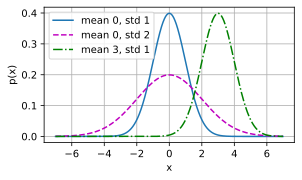

In [41]:
x = np.arange(-7, 7, 0.01)

#Mean and standard deviation pairs -> mu and sigma is mean and standard distribution
params = [(0,1), (0,2), (3,1)]
d2l.plot(x, [normal(x,mu,sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5,2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])

# 3.2 Object-Oriented Design for Implementation

In [42]:
import time
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

utilities, 객체 지향 도움되라고 몇개 유틸리티 함수들

https://technote.kr/248 <- setattr 함수 사용법


In [43]:
def add_to_class(Class): #utility 1 -> 클래스 담기용
  def wrapper(obj):
    setattr(Class, obj.__name__, obj)
  return wrapper

#setattr(object, name, value)
#object에 존재하는 속성의 값을 바꾸거나, 새로운 속성을 생성하여 값을 부여한다.

작동하는거 한 번 보자!

In [44]:
class A: #create new class
  def __init__(self): 
    self.b = 1

a = A()

데코레이터는 함수에 무언가 내용을 추가하고 싶을 때 사용하는 기능입니다. 단순히 함수에 바로 내용을 추가하지 않고 데코레이터를 쓰는 이유는 다른 함수들에도 반복적으로 추가할 수 있도록 관리하기 위해서입니다. 

In [45]:
@add_to_class(A)
def do(self):
  print('Class attribute "b" is', self.b)

a.do() #a는 원래 do 가 멤버 함수로 없었는데 데코레이트로 추가 사용이 가능해짐

Class attribute "b" is 1


In [46]:
class HyperParameters: #untility 2 -> save all arguments in a class's __init__
  def save_hyperparameters(self, ignore=[]):
    raise NotImplemented #구현되지 않음을 의미

In [47]:
# Call the fully implemented HyperParameters class saved in d2l
class B(d2l.HyperParameters):
  def __init__(self, a, b, c):
    self.save_hyperparameters(ignore=['c'])
    print('self.a =', self.a, 'self.b =', self.b)
    print('There is no self.c =', not hasattr(self, 'c'))

b = B(a=1, b=2, c=3)

self.a = 1 self.b = 2
There is no self.c = True


hasattr(object, name)
object의 속성(attribute) 존재를 확인한다.
만약 argument로 넘겨준 object 에 name 의 속성이 존재하면 True, 아니면 False를 반환한다. 

In [48]:
class ProgressBoard(d2l.HyperParameters):  #utility 3 -> plot 돕기
    """The board that plots data points in animation."""
    def __init__(self, xlabel=None, ylabel=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 ls=['-', '--', '-.', ':'], colors=['C0', 'C1', 'C2', 'C3'],
                 fig=None, axes=None, figsize=(3.5, 2.5), display=True):
        self.save_hyperparameters()

    def draw(self, x, y, label, every_n=1):
        raise NotImplemented

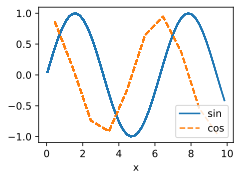

In [49]:
board = d2l.ProgressBoard('x')
for x in np.arange(0, 10, 0.1):
    board.draw(x, np.sin(x), 'sin', every_n=2)
    board.draw(x, np.cos(x), 'cos', every_n=10) #사용 예시

아래 내용이 훈련이 되는 큰 과정이라고 보면 된다.

class 1 : Model class

In [50]:
class Module(nn.Module, d2l.HyperParameters):
  def __init__(self, plot_train_per_epoch=2, plot_valid_per_epoch=1):
    super().__init__()
    self.save_hyperparameters()
    self.borad = ProgressBoard()

  def loss(self, y_hat, y):
    raise NotImplemented
  
  def forward(self, X):
    assert hasattr(self, 'net'), 'Neural network is defined'
    return self.net(X)

  def plot(self, key, value, train):
    """Plot a point in animation"""
    assert hasattr(self, 'trainer'), 'Trainer is not defined'
    self.boarad.xlabel = 'epoch'
    if train:
      x = self.trainer.train_batch_idx / self.trainer.num_train_batches
      n = self.trainer.num_train_batches / self.plot_train_per_epoch
    else:
      x = self.trainer.epoch + 1
      n = self.trainer.num_val_batches / self.plot_valid_per_epoch
    self.board.draw(x, value.to(d2l.cpu()).detach().numpy(),
                        ('train_' if train else 'val_') + key, every_n=int(n))
  
  def training_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=True)
    return l
  
  def validation_step(self, batch):
    l = self.loss(self(*batch[:-1]), batch[-1])
    self.plot('loss', l, train=False)

  def configure_optimizers(self):
    raise NotImplemented

class 2 : Data

In [51]:
class DataModule(d2l.HyperParameters):  
    """The base class of data."""
    def __init__(self, root='../data', num_workers=4):
        self.save_hyperparameters()

    def get_dataloader(self, train):
        raise NotImplementedError

#아래 두개가 결국 내보내는거
    def train_dataloader(self):
        return self.get_dataloader(train=True)

    def val_dataloader(self):
        return self.get_dataloader(train=False)

class 3 : Training

In [52]:
class Trainer(d2l.HyperParameters):
  def __init__(self, max_epochs, num_gpus=0, gradient_clip_val=0):
    self.save_hyperparameters()
    assert num_gpus == 0, 'No GPU support yet'

  def prepare_dat(self, data): #class 2가 input
    self.train_dataloader = data.train_dataloader()
    self.val_dataloader = data.val_dataloader()
    self.num_train_batches = len(self.train_dataloader)
    self.num_val_batches = (len(self.val_dataloader) if self.val_dataloader is not None else 0)

  def prepare_model(self, model): #class 1이 input
    model.trainer = self
    model.board.xlim = [0, self.max_epochs]
    self.model = model
  
  def fit(self, model, data): #이게 최종 key method
    self.prepare_data(data)
    self.prepare_model(model)
    self.optim = model.configure_optimizers()
    self.epoch = 0
    self.train_batch_idx = 0
    self.val_batch_idx = 0
    for self.epoch in range(self.max_epochs):
      self.fit_epoch()
  
  def fit_epoch(self):
    raise NotImplemented

# 3.3 Synthetic Regression Data

In [53]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

Generating Dataset

X는 데이터셋인건데 결국 dim = 1000x2형태, 1000이 데이터 개수, 2는 특징 개수겠지(x1, x2)

In [54]:
class SyntheticRegressionData(d2l.DataModule):
  def __init__(self, w, b, noise=0.01, num_train=1000, num_val=1000,
               batch_size=32):
    super().__init__() 
    self.save_hyperparameters()
    n = num_train + num_val #total
    self.X = torch.randn(n, len(w)) #random하게 generate
    noise = torch.randn(n,1) * noise
    self.y = torch.matmul(self.X, w.reshape((-1,1))) + b + noise #우리가 최종적으로 본 식

In [55]:
data = SyntheticRegressionData(w=torch.tensor([2,-3.4]), b=4.2)

In [56]:
print('features:', data.X[0], '\nlabel:',data.y[0])

features: tensor([0.0353, 0.3024]) 
label: tensor([3.2485])


각 row는 2차 벡터로 이루어진거고, label은 스칼라네 (예측값)

Reading the Dataset

미니배치사이즈 만큼 데이터를 읽어오는 과정의 함수야

In [57]:
@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train): #Data_moduel 클래스에 있는 거랑 같은 함수야
  if train:
    indices = list(range(0, self.num_train)) #ex 0~999
    #The example are read in random order
    random.shuffle(indices)
  else:
    indices = list(range(self.num_train, self.num_train + self.num_val)) #ex 1000~1999
  for i in range(0, len(indices), self.batch_size): #mini_batch 만큼
    batch_indices = torch.tensor(indices[i:i+self.batch_size])
    yield self.X[batch_indices], self.y[batch_indices]

In [58]:
 X, y = next(iter(data.train_dataloader()))
 print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


Concise Implementation of the Data Loader

new data loader -> more efficient

In [59]:
@d2l.add_to_class(d2l.DataModule)
def get_tensorloader(self, tensors, train, indices=slice(0, None)):
  tensors = tuple(a[indices] for a in tensors)
  dataset = torch.utils.data.TensorDataset(*tensors)
  return torch.utils.data.DataLoader(dataset, self.batch_size, shuffle=train)

@d2l.add_to_class(SyntheticRegressionData)
def get_dataloader(self, train):
  i = slice(0, self.num_train) if train else slice(self.num_train, None)
  return self.get_tensorloader((self.X, self.y), train, i)

In [60]:
X , y = next(iter(data.train_dataloader()))
print('X shape:', X.shape, '\ny shape:', y.shape)

X shape: torch.Size([32, 2]) 
y shape: torch.Size([32, 1])


In [61]:
len(data.train_dataloader()) #결론 : batch_size

32

# 3.4 Linear Regression Implementation from Scratch

위에는 그냥 하나의 간단한 2-dim 짜리 예시를 본거니까, 실전 데이터를 가지고 활용해볼거야

In [62]:
%matplotlib inline
import torch
from d2l import torch as d2l

Defining the Model

In [71]:
class LinearRegressionScratch(d2l.Module):
  def __init__(self, num_inputs, lr, sigma=0.01): #lr = learning rate
    super().__init__()
    self.save_hyperparameters()
    self.w = torch.normal(0, sigma, (num_inputs, 1), requires_grad=True) 
    self.b = torch.zeros(1, requires_grad=True)
    #가중지는 noraml distribution을 따르도록 mean=0, sigma=0.01
    #bias = 0로

결국 결과값은 matrix(X) & vector(w) multiplication의 결과인 vector이고 그 vector에 scalar인 bias를 더하면 broadcasting에 의해 모든 weight에 bias가 더해질거야

In [72]:
@d2l.add_to_class(LinearRegressionScratch)
def forward(self, X):
  """The linear regression model."""
  return torch.matmul(X, self.w) + self.b

Defining the Loss Funcion

In [73]:
@d2l.add_to_class(LinearRegressionScratch)
def loss(self, y_hat, y):
  l = (y_hat - y)**2 / 2
  return l.mean() #MSE, shape은 y_hat이랑 같아

Defining the Optimization Algorithm(여기선 SGD)

In [78]:
class SGD(d2l.HyperParameters):
  def __init__(self, params, lr):
    """Minibatch stochastic gradient descent"""
    self.save_hyperparameters()

  def step(self):
    for param in self.params:
      param -= self.lr * param.grad # p = p - gradient 라는 핵심 경사하강 수식

  def zero_grad(self):
    for param in self.params:
      if param.grad is not None:
        param.grad.zero_()

아래 함수는 instance of SGD 클래스를 리턴해

In [79]:
@d2l.add_to_class(LinearRegressionScratch)
def configure_optimizers(self):
  return SGD([self.w, self.b], self.lr)

Training

트레이닝 과정 요약

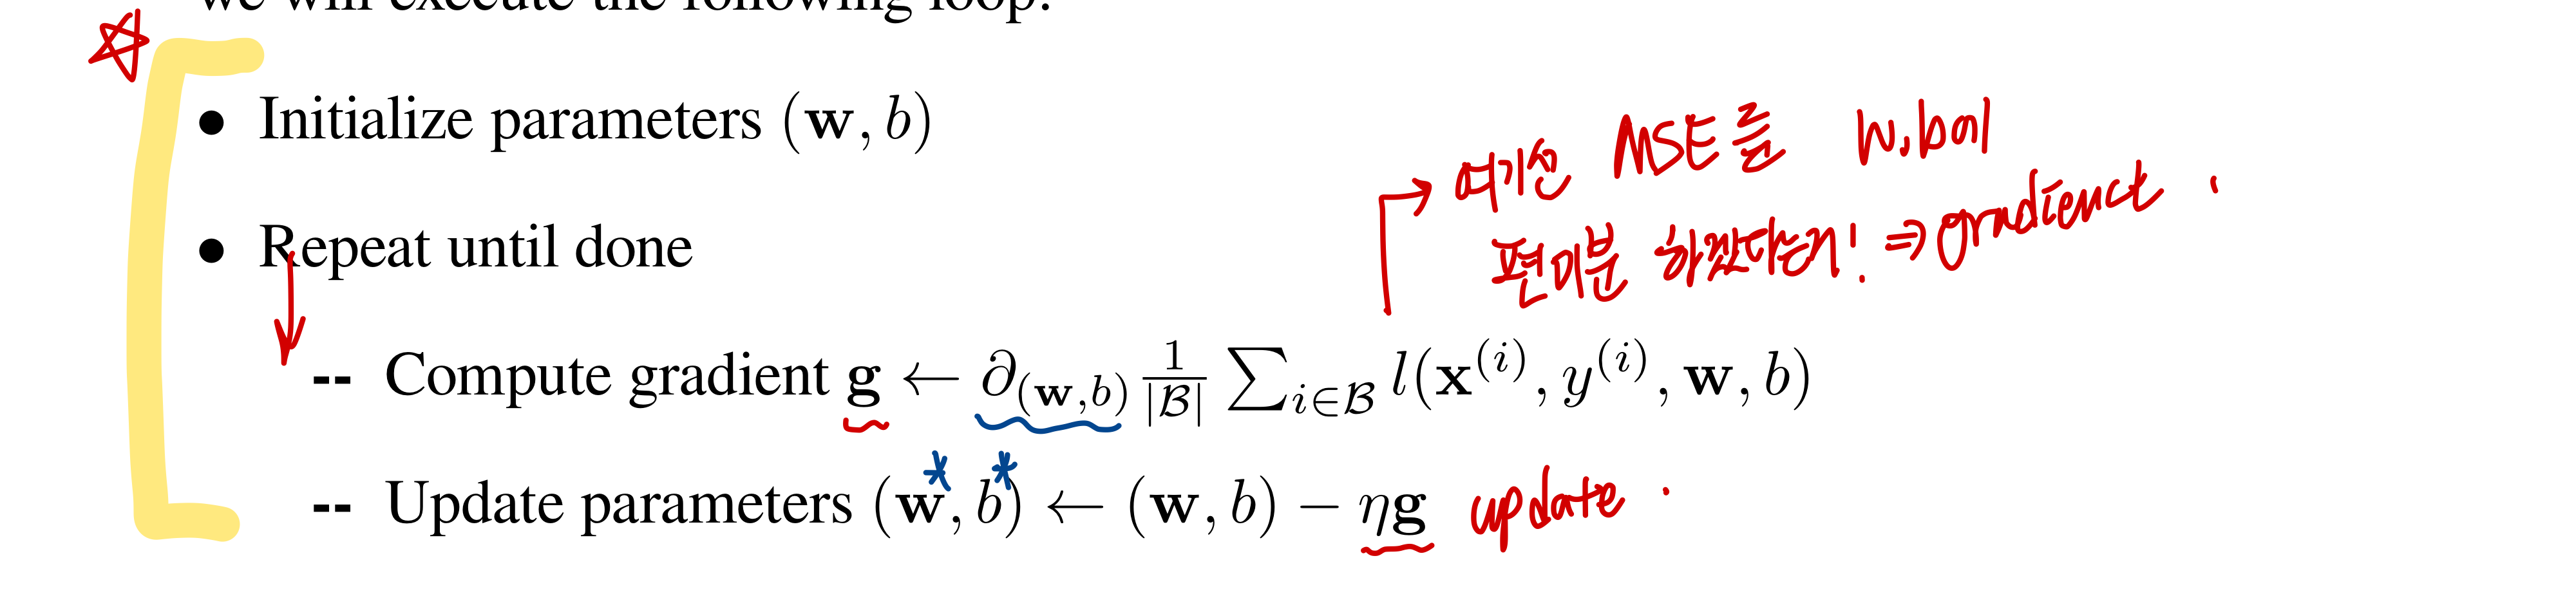

In [80]:
@d2l.add_to_class(d2l.Trainer)
def prepare_batch(self, batch):
  return batch

@d2l.add_to_class(d2l.Trainer)
def fit_epoch(self):
  self.model.train() #train
  for batch in self.train_dataloader:
    loss = self.model.training_step(self.prepare_batch(batch))
    self.optim.zero_grad() #항상 buffer 초기화
    with torch.no_grad():
      loss.backward() #auto gradient
      if self.gradient_clip_val > 0 : #이게 뭔지는 나중에 알려준데 from d2l
        self.clip_gradients(self.gradient_clip_val, self.model)
      self.optim.step()
    self.train_batch_idx +=1

  if self.val_dataloader is not None:
    return
  self.model.eval() #evaluation
  for batch in self.val_dataloader:
    with torch.no_grad():
      self.model.validation_step(self.prepare_batch(batch))
      self.val_batch_idx +=1

train을 위한 과정 complete

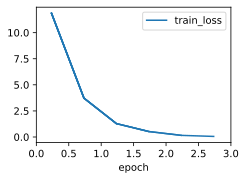

In [81]:
model = LinearRegressionScratch(2, lr=0.03)
data = d2l.SyntheticRegressionData(w=torch.tensor([2, -3.4]), b=4.2)
trainer = d2l.Trainer(max_epochs=3)
trainer.fit(model, data)

학습된 Parameter 보기

In [82]:
print(f'error in estimating w: {data.w - model.w.reshape(data.w.shape)}')
print(f'error in estimating b: {data.b - model.b}')

error in estimating w: tensor([ 0.0773, -0.1185], grad_fn=<SubBackward0>)
error in estimating b: tensor([0.1829], grad_fn=<RsubBackward1>)


# 3.5 Concise Implementation of Linear Regression